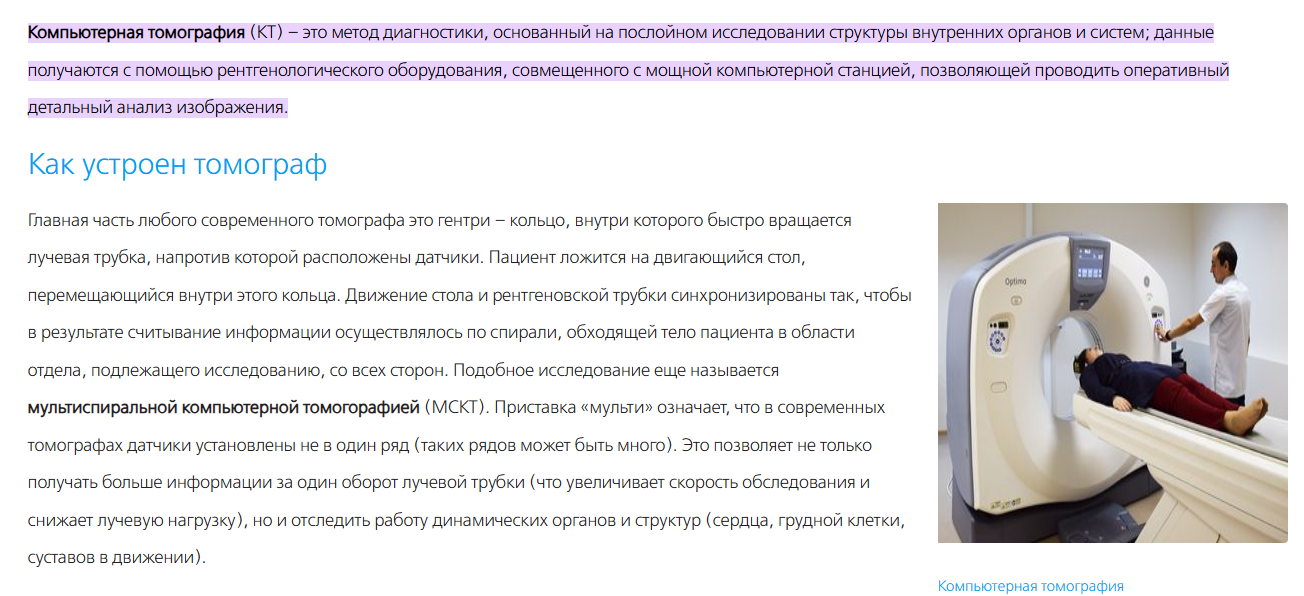

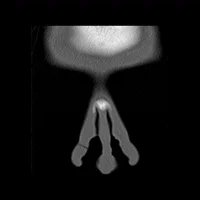

In [1]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV, RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#!unzip ct_slices.zip

In [3]:
df = pd.read_csv("/content/slice_localization_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53500 entries, 0 to 53499
Columns: 386 entries, patientId to reference
dtypes: float64(385), int64(1)
memory usage: 157.6 MB


признак 1. Идентификатор пациента: каждый идентификатор идентифицирует отдельного пациента.

признаки 2 - 241: Гистограмма, описывающая костные структуры.

признаки 242 - 385: Гистограмма, описывающая воздушные включения.

признак 386. Ссылка: Относительное расположение изображения на осевой оси (значение класса). Значения находятся в диапазоне [0; 180], где 0 обозначает макушку головы, а 180 — подошвы ног.

In [5]:
# Сколько снимков на каждого пациента
53500 / 74

722.972972972973

In [6]:
df.head()

,patientId,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
0,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.980381,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.803851
1,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.745726
2,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.687600
3,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.629474
4,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.976833,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.571348


В контексте КТ "бины" относятся к небольшим трехмерным элементам, из которых состоит изображение. Когда КТ-сканер собирает данные, он разбивает область сканирования на множество бинов.

"За пределами" означает, что бины расположены за пределами области интереса (имеют значения -0.25) или за пределами тела пациента. Эти бины могут содержать воздух, который окружает тело пациента, или другие структуры, которые не имеют отношения к обследованию.

In [7]:
import matplotlib.pyplot as plt

# EDA

In [8]:
df.reference.describe()

,reference
count,53500.000000
mean,47.028039
std,22.347042
min,1.738733
25%,29.891607
50%,43.987893
75%,63.735059
max,97.489115


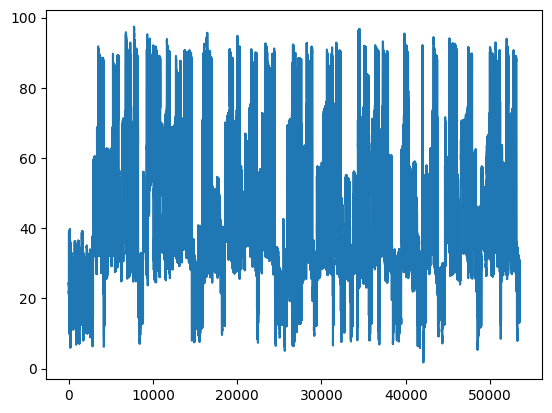

In [9]:
plt.plot(df.reference);

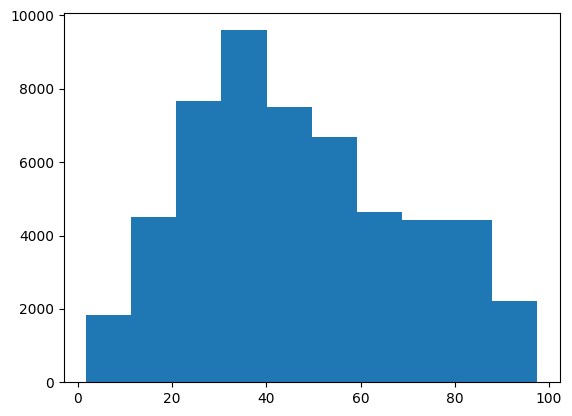

In [10]:
plt.hist(df.reference);

возможно, что у каждого пациента было сканирование своей области

In [11]:
df.groupby('patientId')['reference'].mean()

,reference
patientId,
0,22.850115
1,21.710394
2,21.706657
3,23.571468
4,22.520414
...,...
92,45.151765
93,59.736578
94,59.322702


In [12]:
df.isna().sum()

,0
patientId,0
value0,0
value1,0
value2,0
value3,0
...,...
value380,0
value381,0
value382,0
value383,0


In [13]:
df.dropna()

,patientId,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.980381,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.803851
1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.745726
2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.687600
3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.977008,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.629474
4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.976833,0.0,0.000000,0.000000,0.0,0.0,-0.25,-0.25,21.571348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,96,0.591906,0.357764,0.000000,0.000000,0.552321,0.795304,0.946697,0.952227,0.84395,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,29.290398
53496,96,0.612313,0.000000,0.000000,0.000000,0.864160,0.820531,0.000000,0.938813,0.94374,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,27.945721
53497,96,0.612313,0.000000,0.000000,0.000000,0.864160,0.820531,0.000000,0.938813,0.94374,...,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,27.945721
53498,96,0.634921,0.904555,0.956087,0.980208,0.157664,0.000000,-0.250000,-0.250000,-0.25000,...,-0.25,0.000000,0.0,0.994967,0.806688,0.0,0.0,-0.25,-0.25,14.582997


In [14]:
df.isna().sum()

,0
patientId,0
value0,0
value1,0
value2,0
value3,0
...,...
value380,0
value381,0
value382,0
value383,0


видим, что пропусков нет

In [15]:
df.describe()

,patientId,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
count,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,...,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000,53500.000000
mean,47.075701,0.059627,0.071558,0.145819,0.218728,0.274762,0.276189,0.204531,0.062281,-0.042025,...,-0.029404,0.182913,0.320112,0.359373,0.342889,0.266091,0.083049,-0.031146,-0.154524,47.028039
std,27.414240,0.174243,0.196921,0.300270,0.359163,0.378862,0.369605,0.351294,0.292232,0.268391,...,0.085817,0.383333,0.463517,0.478188,0.471811,0.437633,0.279734,0.098738,0.122491,22.347042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.250000,-0.250000,...,-0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-0.250000,-0.250000,1.738733
25%,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,29.891607
50%,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,43.987893
75%,70.000000,0.000000,0.000000,0.000000,0.446429,0.684477,0.662382,0.441412,0.000000,0.000000,...,0.000000,0.000000,0.996286,0.999677,0.999560,0.949478,0.000000,0.000000,0.000000,63.735059
max,96.000000,1.000000,1.000000,1.000000,1.000000,0.998790,0.996468,0.999334,1.000000,1.000000,...,0.961279,1.000000,1.000000,1.000000,1.000000,1.000000,0.999857,0.996839,0.942851,97.489115


тут видим, что масштабировать не надо

In [16]:
for_drop = []
for i in df.columns:
  if len(df[i].value_counts()) == 1:
    print(i, len(df[i].value_counts()))
    for_drop.append(i)

value59 1
value69 1
value179 1
value189 1
value351 1


In [17]:
for_drop

['value59', 'value69', 'value179', 'value189', 'value351']

In [18]:
df.value59.value_counts()

,count
value59,
-0.25,53500


In [19]:
df.value311.value_counts()

,count
value311,
-0.250000,32406
0.000000,21093
0.670476,1


In [20]:
cat_features = df.nunique()[df.nunique() < 4].index
cat_features

Index(['value38', 'value39', 'value48', 'value49', 'value59', 'value68',
       'value69', 'value78', 'value79', 'value88', 'value89', 'value168',
       'value169', 'value178', 'value179', 'value188', 'value189', 'value199',
       'value263', 'value271', 'value279', 'value287', 'value295', 'value311',
       'value335', 'value343', 'value351', 'value359', 'value367'],
      dtype='object')

In [21]:
d = pd.DataFrame({'value':[], 'amount_025':[]})
for i in df.columns:
  amount_025 = list(df[i].values).count(-0.25) / len(df[i])
  if amount_025 > 0.75:
    d.loc[len(d)] = [i, amount_025 * 100]
d = d.sort_values(by='amount_025', ascending=False)
d.head(20)

,value,amount_025
10,value69,100.000000
7,value59,100.000000
23,value179,100.000000
26,value189,100.000000
41,value351,100.000000
35,value279,99.998131
25,value188,98.422430
22,value178,98.422430
29,value199,98.291589
20,value169,98.291589


In [22]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 10 to 2
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       44 non-null     object 
 1   amount_025  44 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [23]:
for_drop = d.value.values

In [24]:
for_drop

array(['value69', 'value59', 'value179', 'value189', 'value351',
       'value279', 'value188', 'value178', 'value199', 'value169',
       'value58', 'value68', 'value79', 'value49', 'value9', 'value239',
       'value359', 'value343', 'value129', 'value119', 'value271',
       'value287', 'value350', 'value278', 'value198', 'value168',
       'value78', 'value48', 'value177', 'value187', 'value57', 'value67',
       'value358', 'value342', 'value286', 'value270', 'value209',
       'value89', 'value159', 'value39', 'value197', 'value167',
       'value77', 'value47'], dtype=object)

In [25]:
df = df.drop(for_drop, axis = 1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53500 entries, 0 to 53499
Columns: 342 entries, patientId to reference
dtypes: float64(341), int64(1)
memory usage: 139.6 MB


In [27]:
RANDOM_STATE = 42
TEST_SIZE = 0.3
X = df.drop('reference', axis=1)
y = df.reference
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

# Linear Regression

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
preds = model.predict(X_test)

In [30]:
r2_score(y_test, preds)

0.8589666436602236

<Axes: >

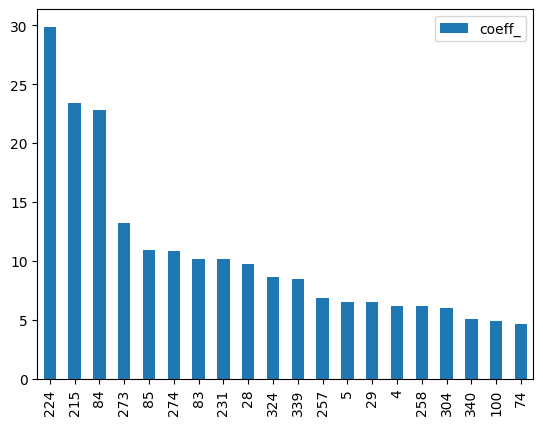

In [31]:
coeff_ = model.coef_
vals = model.feature_names_in_
lin_vals = pd.DataFrame({'value':vals, 'coeff_':coeff_}).sort_values(by='coeff_', ascending=False)
lin_vals[:20].plot(kind='bar')

In [32]:
df2 = pd.read_csv("/content/slice_localization_data.csv")

In [33]:
X2 = df2.drop('reference', axis=1)
y2 = df2.reference
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [34]:
model2 = LinearRegression()
model2.fit(X2_train, y2_train)
preds2 = model2.predict(X2_test)
r2_score(y2_test, preds2)

0.863082615421082

<Axes: >

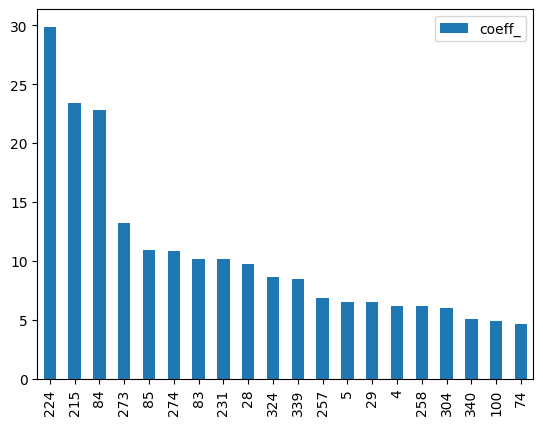

In [35]:
coeff_ = model.coef_
vals = model.feature_names_in_
lin_vals = pd.DataFrame({'value':vals, 'coeff_':coeff_}).sort_values(by='coeff_', ascending=False)
lin_vals[:20].plot(kind='bar')

# LASSO

In [36]:
model = LassoCV()
model.fit(X_train, y_train)
preds = model.predict(X_test)
r2_score(y_test, preds)

0.8559629874330209

<Axes: >

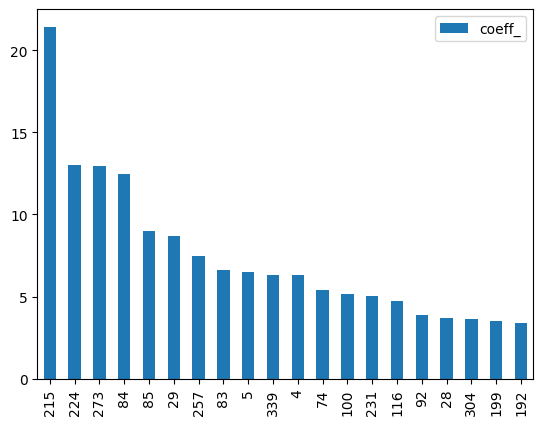

In [37]:
coeff_ = model.coef_
vals = model.feature_names_in_
lin_vals = pd.DataFrame({'value':vals, 'coeff_':coeff_}).sort_values(by='coeff_', ascending=False)
lin_vals[:20].plot(kind='bar')

In [38]:
model2 = LassoCV()
model2.fit(X2_train, y2_train)
preds2 = model2.predict(X2_test)
r2_score(y2_test, preds2)

0.8597289255022137

Feature: 1, Score: -2.78603
Feature: 4, Score: 6.28769
Feature: 5, Score: 6.50107
Feature: 6, Score: 3.32974
Feature: 8, Score: 2.83055
Feature: 9, Score: -5.89345
Feature: 19, Score: 2.00092
Feature: 22, Score: -1.32787
Feature: 27, Score: -3.71480
Feature: 28, Score: 3.71401
Feature: 29, Score: 8.68068
Feature: 32, Score: -1.10265
Feature: 35, Score: -3.36862
Feature: 36, Score: -4.02693
Feature: 38, Score: -3.72186
Feature: 39, Score: -2.97814
Feature: 41, Score: -2.83268
Feature: 43, Score: -2.53436
Feature: 45, Score: -1.52450
Feature: 46, Score: -2.19694
Feature: 49, Score: -1.12538
Feature: 51, Score: -1.50450
Feature: 54, Score: 1.74872
Feature: 56, Score: -3.03679
Feature: 57, Score: -2.58095
Feature: 58, Score: -2.04912
Feature: 59, Score: -3.60100
Feature: 61, Score: 1.45642
Feature: 62, Score: 1.79598
Feature: 64, Score: 1.45195
Feature: 66, Score: -3.26846
Feature: 68, Score: -1.40029
Feature: 69, Score: -1.06921
Feature: 74, Score: 5.38448
Feature: 77, Score: -1.36544
Fea

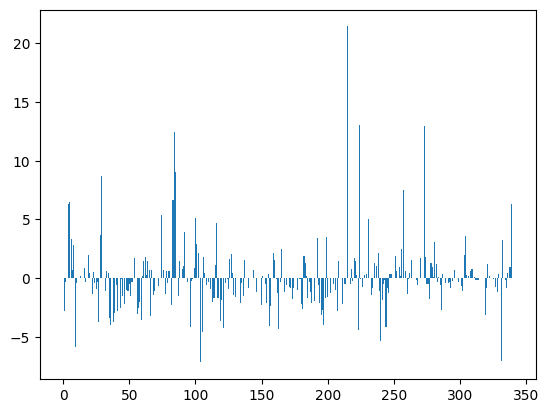

In [39]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
  if abs(v) > 1:
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<Axes: >

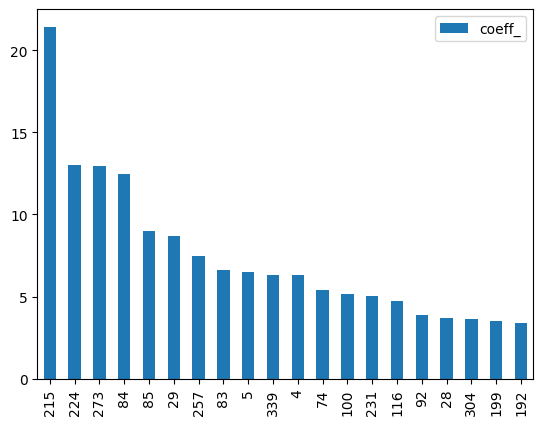

In [40]:
coeff_ = model.coef_
vals = model.feature_names_in_
lin_vals = pd.DataFrame({'value':vals, 'coeff_':coeff_}).sort_values(by='coeff_', ascending=False)
lin_vals[:20].plot(kind='bar')

# RF regressor

In [41]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
r2_score(y_test, preds)

0.9946177050704548

In [42]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
335,value378,1.988631e-01
18,value18,1.951350e-01
198,value228,1.296937e-01
5,value4,1.142557e-01
104,value118,4.557498e-02
...,...,...
308,value347,1.457775e-08
290,value327,7.523108e-09
266,value303,3.190385e-09
224,value255,2.095214e-09


In [43]:
model2 = RandomForestRegressor(n_estimators=10, random_state=42)
model2.fit(X2_train, y2_train)
preds2 = model2.predict(X2_test)
r2_score(y2_test, preds2)

0.9945585629069117

# Полиномиальная регрессия

In [28]:
from sklearn.preprocessing import PolynomialFeatures

In [29]:
X_train.shape

(37450, 341)

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly_features = poly.fit_transform(X_train)
poly_features = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
y_predicted = poly_reg_model.predict(poly_features)
r2_score(y_train, y_predicted)